# Projeto: Rossmann Stores Sales


## Problema de Negócio:
A Rossman é uma rede de drogarias que atua com várias lojas espalhadas na Europa. Foi solicitado, pelo CFO da empresa, uma previsão das vendas das próximas 6 semanas, essa decisão foi tomada por ele depois de várias discussões em reuniões estratégicas de negócio com os gerentes das lojas. O CFO precisa realizar o planejamento das reformas das lojas, cujo orçamento encontra-se conforme as vendas de cada loja. Outro ponto questionado por ele, é obter a proporção de vendas de cada loja nas próximas 6 semanas, além disso houve uma ressalta que um dos gerentes, se tem alguma forma de entender que as lojas por grupos para saber as com menor performance de vends, usando técnicas estatísticas. 

## Causas do problema:

### A Motivação:
    - O CFO requisitou essa solução durante uma reunião de resultados mensais.

### A Causa Raiz do Problema:
    - Investimento para reformas das lojas.

### Quem é o Steakholder:
    - O CFO

### O formato da solucão:
    - Previsão das vendas diárias em  R$, nas próximas 6 semanas;
    - Predições acessadas via celular.

##### DATASET: https://www.kaggle.com/competitions/rossmann-store-sales/data

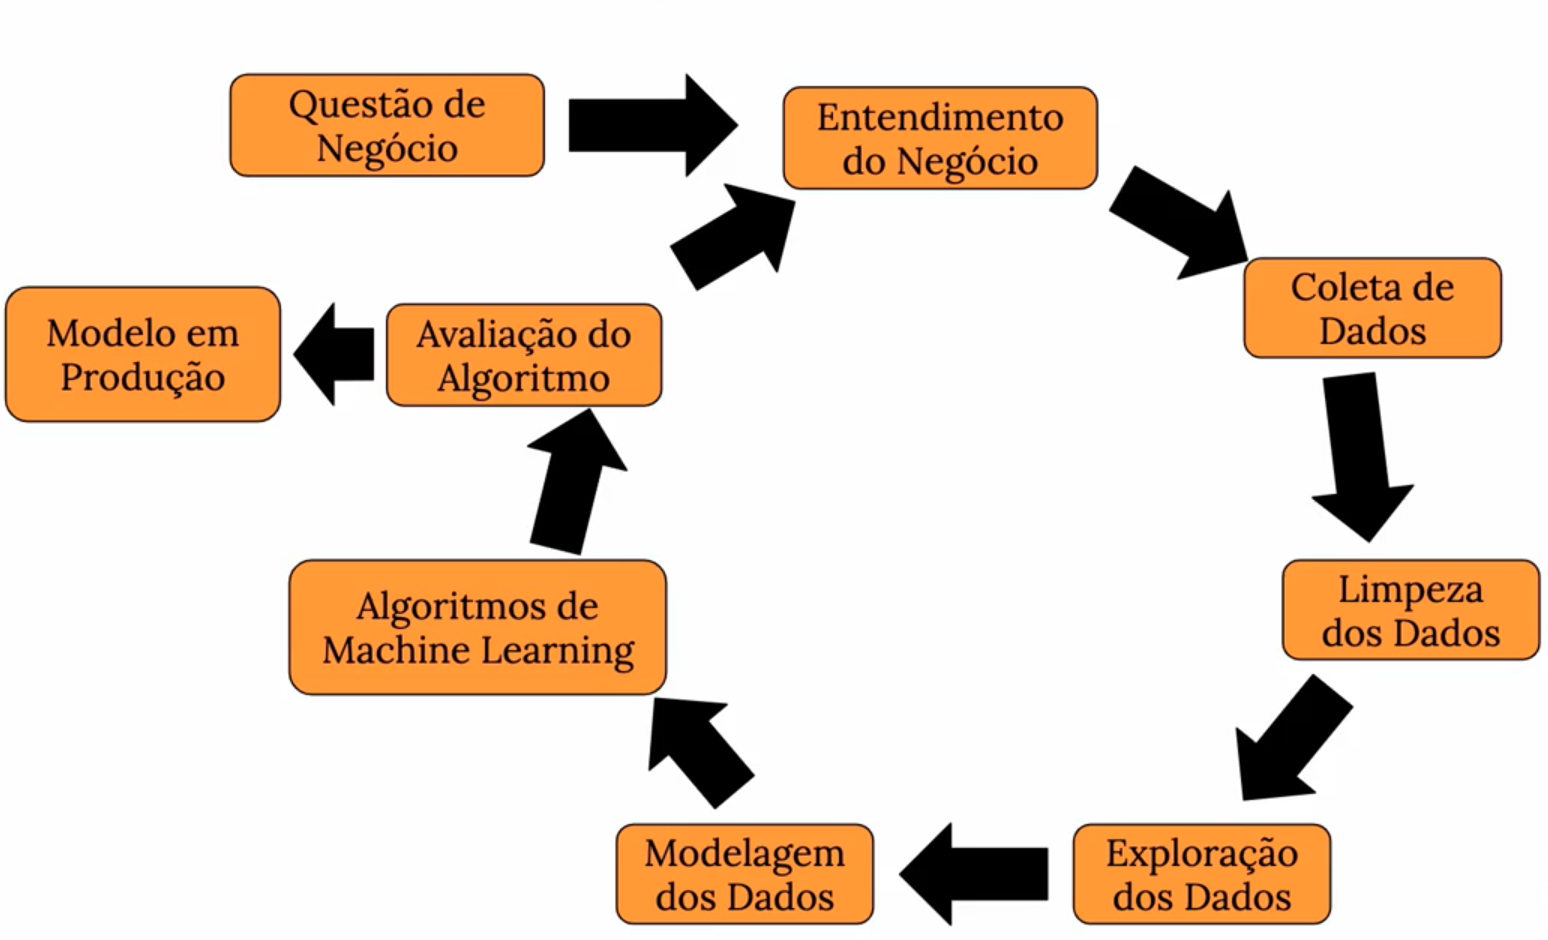

In [5]:
Image("/Users/joaofmoura/Desktop/Aulinhas/Projetos/rossmann-store-sales/img/crisp.png")

# 0.0 IMPORTS

In [34]:
import pandas as pd
import inflection #Using underscore mode
import math 
import numpy as np
import seaborn as sns
import datetime as datetime


from matplotlib            import pyplot as plt
from IPython.display       import Image

0.1 HELPER FUNCTIONS

In [7]:
plt.rcParams["figure.figsize"] = (20,10) # Setar o tamanho padrão das figuras/gráficos

0.2. LOADING DATA

In [8]:
df_sales_raw = pd.read_csv( "/Users/joaofmoura/Desktop/Aulinhas/Projetos/rossmann-store-sales/train.csv", low_memory=False)
df_store_raw = pd.read_csv( "/Users/joaofmoura/Desktop/Aulinhas/Projetos/rossmann-store-sales/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

# 1.0. DATA DESCRIPTION

In [9]:
df1 = df_raw.copy()

# 1.1. Rename Columns

In [10]:
cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#Renane
df1.columns = cols_new

# 1.2. Data Dimensions

In [11]:
print ("Number of Rows:{}" .format( df1.shape[0]))
print ("Number of Columns:{}" .format( df1.shape[1]))

Number of Rows:1017209
Number of Columns:18


# 1.3. Data Types

In [12]:
df1["date"] = pd.to_datetime (df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.4. Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5. Fillout NA 

### Por que preencher os NA - Pois o modelo não entende os dados faltantes e para tentar aproveitar a maior quantidade possível de dados para que o algoritmo entenda o padrão. 

In [14]:
#competition_distance - Usei 200.000 que é um valor maior que o máximo.   (lambda x = fx)
df1 ["competition_distance"] = df1 ["competition_distance"].apply (lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month - The store has no nearby competitor or we don't have the date when the competitor's store was opened. (To solve the NA I replace it with the month value on that line)
df1 ["competition_open_since_month"] = df1.apply(lambda x: x["date"].month if math.isnan ( x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

#competition_open_since_year - The store has no nearby competitor or we don't have the date when the competitor's store was opened.  (To solve the NA I replace it with the year value on that line)    
df1 ["competition_open_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan ( x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)
                          
#promo2_since_week - The NAs are because the store didn't participate the promotion, so I'm going to replace the NAs with the date value on each line.
df1 ["promo2_since_week"] = df1.apply(lambda x: x["date"].week if math.isnan ( x["promo2_since_week"]) else x["promo2_since_week"], axis=1)        

#promo2_since_year - The NAs are because the store didn't participate in the promotion, so I'm going to replace the NAs with the date value on each line. 
df1 ["promo2_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan ( x["promo2_since_year"]) else x["promo2_since_year"], axis=1)    

#promo_interval - slip the list, if the interval is on the list, the promo2 is activate    
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

df1["promo_interval"].fillna(0, inplace=True)

df1["month_map"] = df1["date"].dt.month.map( month_map)

df1 ["is_promo"] = df1[["promo_interval", "month_map"]].apply( lambda x: 0 if x["promo_interval"] == 0 else 1 if x ["month_map"] in x ["promo_interval"].split (",") else 0, axis=1)

In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

# 1.6. Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
# competition_open_since_month - should be a int because its the month number ( 1 - january)
df1 ["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)

#competition_open_since_year - should be a int because the year is represented by numbers 
df1 ["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

#promo2_since_week - should be int because week is a number
df1 ["promo2_since_week"] = df1["promo2_since_week"].astype(int)

#promo2_since_year - should be int because year is a number
df1 ["promo2_since_year"] = df1["promo2_since_year"].astype(int)

# 1.7. Descriptive Statistical

Gain business knowledge and detect some errors through dispersion metrics (which say if I am very concentrated near the mean or not - variance, standard deviation, range) and central tendency (mean and median). 

- Skew: deformation of my distribution according to normal (left positive and right negative);
- Kurtosis: data concentration;
- Standard deviation: distance of points from the mean;
- Range: difference between minimum and maximum;

- num_attributes: numerical collumns;
- cat_attributes: categortical collumns (strings).

In [18]:
num_attributes = df1.select_dtypes( include =["int64", "float64"])
cat_attributes = df1.select_dtypes( exclude =["int64", "float64", "datetime64[ns]"])

# 1.7.1 Numerical Attributes

In [19]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
round(m,2)

# Analisando a coluna de vendas (variavél resposta):
    # Média: Quantidade média de vendas nas lojas. (tendência central)
    # Desvio Padrão: A dispersão entre os valores referente a média.()
    # Min: O valor mínimo.
    # 50% Mediana:
    # Máx: O valor máximo. 

# Calcular dispersão dos dados (coeficiente de variação) = std / mean 
    # Se valor prox. 1 - dados muitos dispersos 
    # Se valor prox. 0 - dados condensados

# Premissas de Machine Learning.
    # Dados são independentes;
    # A disribuição da variável resposta é normal - distribuição simétrica em relação à média (Skew prox. de zero). 

# Skew: valor próximo de zero mostra que não está pegando nenhum viés, sendo a distribuição simétrica = melhor meus resultados.
# Kutosis: Quantos dados tem muito distante do desvio padrão (calda longa)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.43,558.0,321.91,-0.00,-1.20
1,day_of_week,1.0,7.0,6.0,4.00,4.0,2.00,0.00,-1.25
2,sales,0.0,41551.0,41551.0,5773.82,5744.0,3849.92,0.64,1.78
3,customers,0.0,7388.0,7388.0,633.15,609.0,464.41,1.60,7.09
4,open,0.0,1.0,1.0,0.83,1.0,0.38,-1.76,1.09
5,promo,0.0,1.0,1.0,0.38,0.0,0.49,0.49,-1.76
6,school_holiday,0.0,1.0,1.0,0.18,0.0,0.38,1.68,0.82
7,competition_distance,20.0,200000.0,199980.0,5935.44,2330.0,12547.65,10.24,147.79
8,competition_open_since_month,1.0,12.0,11.0,6.79,7.0,3.31,-0.04,-1.23
9,competition_open_since_year,1900.0,2015.0,115.0,2010.32,2012.0,5.52,-7.24,124.07


/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

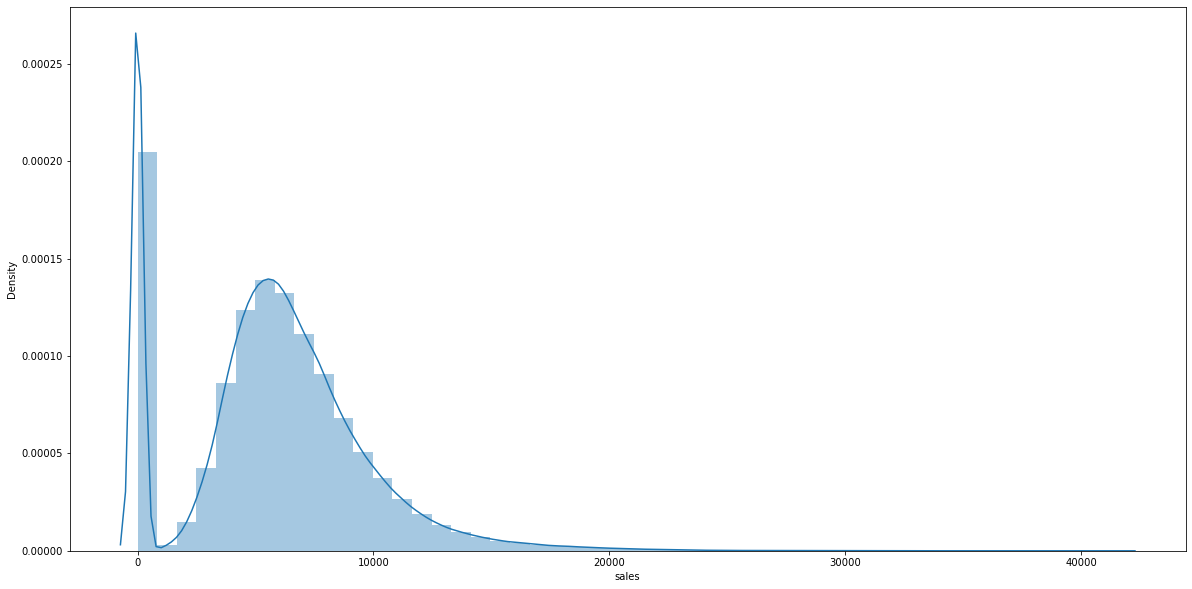

In [20]:
sns.distplot(df1["sales"])

/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

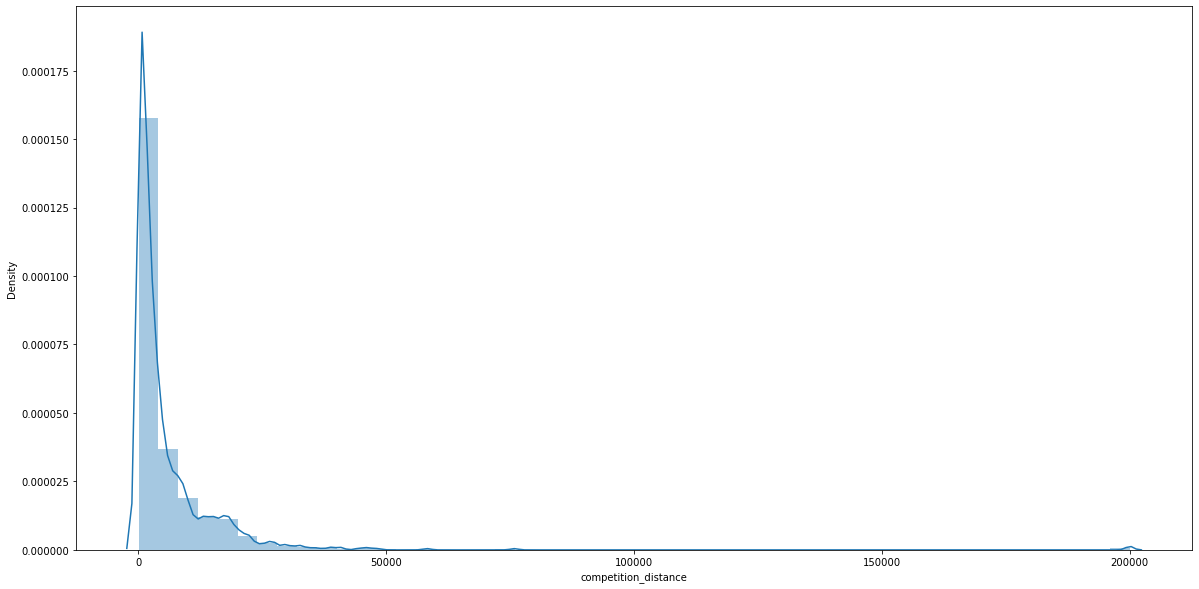

In [21]:
sns.distplot(df1["competition_distance"])

# Analysing "competition_distance" - Os competidores estão muito próximos, por isso que tem um pico muito alto próximo ao zero, lembrando uma distribuição de Poisson 

# 1.7.1 Atributos Categóricos

In [22]:
cat_attributes.apply (lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

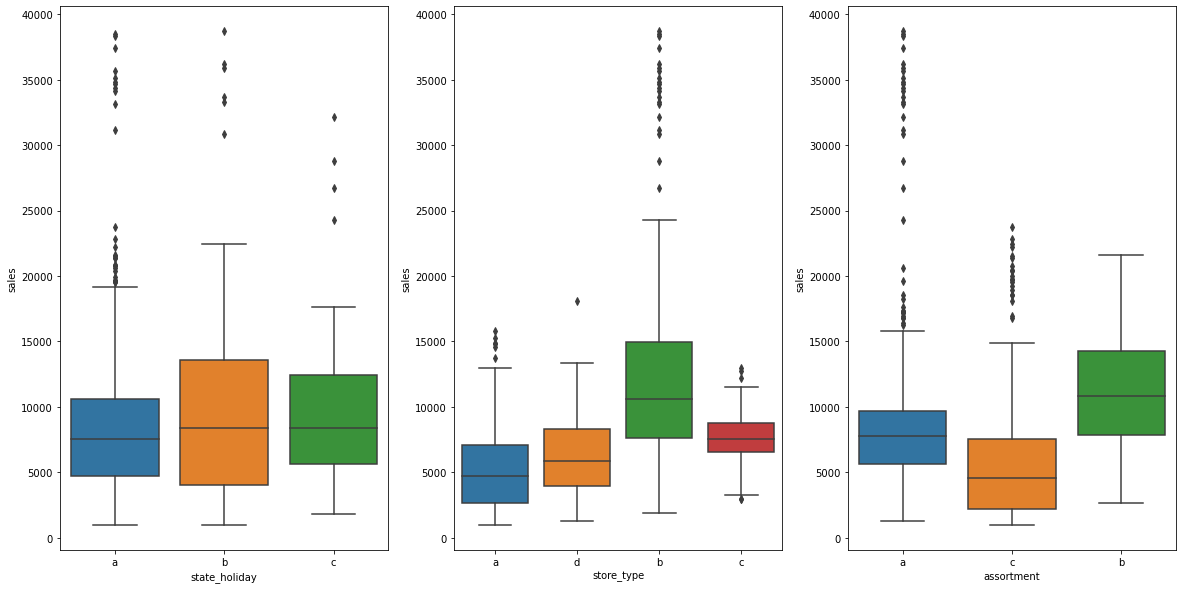

In [23]:
# x=O nome da categoria / y=O que eu quero medir / data=O que você quer mostrar

aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"]>0)] #Preciso fazer esse filtro pois as dimnesões das variáveis estão muito diferentes para excluir os dias que as lojas estão fechadas.

plt.subplot( 1, 3, 1)
sns.boxplot( x="state_holiday", y="sales", data=aux1)

plt.subplot( 1, 3, 2)
sns.boxplot( x="store_type", y="sales", data=aux1)

plt.subplot( 1, 3, 3)
sns.boxplot( x="assortment", y="sales", data=aux1)

# Explicando o Boxplot: Gráfico para análise comparativa 

## Abaixo do Traço inferior - Outliers: q1-1,5.i
## Quartil 25%: q1
## Quartil 50% - Mediana: Representada pela linha do meio 
## Quartil 75%: q3
## Quartil 100%: Valor máximo
## Acima do Traço superior - Outliers: q3+1,5.i
### i = q3-q1 

###State_holiday - b e c tem mediana muito proximas. b tem um equilibrio entre os quartils. 
###Store_type - loja b tem muito mais outliers que as outras e a mediana de vendas é maior. na loja c tem dados poucos volumosos perto da mediana
###Assortments - b tem um mix de produtos bem maior que as outras, o a tem muito mais outliers. 

Update do Progresso do Projeto do Rossaman:
- Questão de Negócio: Entendi que precisava ser feito uma previsão de vendas por lojas nas próximas 6 semanas. 
- Entendimento do Negócio: A dificiculdade do CEO encontrar a quantidade de dinheiro que irá ser investido na reforma das lojas. 
- Limpeza dos daods - Garantir que os tipos de dados estão corretos, garantir que os NAs foram substituidos baseados em critérios e entender a dimensão dos dados. 

Exploração dos dados: 
- Criar as variaveis
- lista de hipoteses 
- Validar as hipóteses

Feature Engineering 

- Porque fazer? Ter as variáveis disponíveis para estudo durante a Analise Exploratória de Dados. 

# 2.0. FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

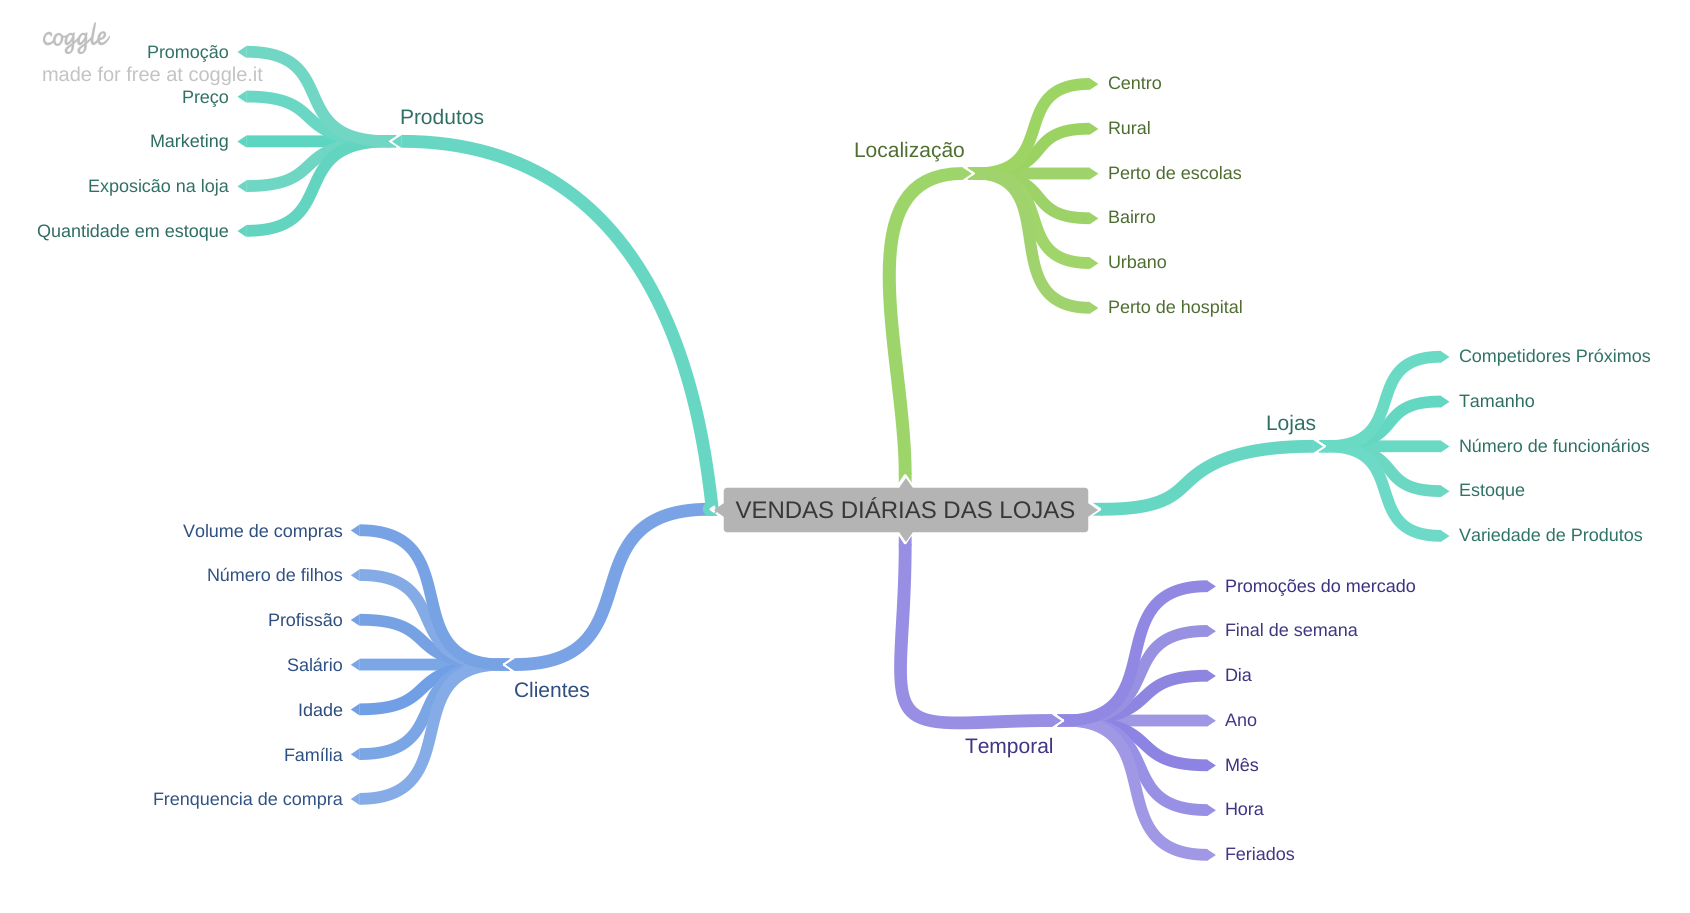

In [25]:
Image("/Users/joaofmoura/Desktop/Aulinhas/Projetos/rossmann-store-sales/img/MindMapHypotesis.png")

# 2.2. Criação das Hipóteses

## 2.2.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais;

**2.**  Lojas com maior capacidade de estoque deveriam vender mais;

**3.**  Lojas com maior porte deveriam vender mais;

**4.**  Lojas com maior variedade de produtos deveriam vender mais;

**5.**  Lojas com competidores mais próximos deveriam vender menos;

**6.** Lojas com competidores à mais tempo deveriam vendem mais.


## 2.2.2. Hipoteses Produto


**1.** Lojas que investem mais em Marketing deveriam vender mais;

**2.** Lojas com maior exposição de produto deveriam vender mais;

**3.** Lojas com produtos com preço menor deveriam vender mais;

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais;

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais;

**7.** Lojas com mais dias de promoção deveriam vender mais;

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

## 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais;

**2.** Lojas deveriam vender mais ao longo dos anos;

**3.** Lojas deveriam vender mais no segundo semestre do ano;

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**5.** Lojas deveriam vender menos aos finais de semana;

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2.4. Lista Final de Hipóteses

**1.** Lojas com maior variedade de produtos deveriam vender mais;
##### Eu tenho os tipos de produtos.

**2.** Lojas com competidores mais próximos deveriam vender menos;
##### Eu tenho informações dos competidores.

**3.** Lojas com competidores à mais tempo deveriam vendem mais;
##### Eu tenho informações dos competidores.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais;
##### Eu tenho informações se a promoção está ativa.

**5.** Lojas com mais dias de promoção deveriam vender mais;
##### Eu tenho informações se a promoção está ativa.

**6.** Lojas com mais promoções consecutivas deveriam vender mais;
##### Eu tenho informações se a promoção está ativa.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais;
##### Eu tenho as informações dos feriados.

**8.** Lojas deveriam vender mais ao longo dos anos;
##### Através da variavel "date" eu consigo criar uma variável ano e obter informações.

**9.** Lojas deveriam vender mais no segundo semestre do ano;
##### Consio extrair os semestres através da variável "date".

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês;
##### Consigo extrair o dia e o mês através da variável "date".

**11.** Lojas deveriam vender menos aos finais de semana;
##### Consio extrair os semestres através da variável "date".

**12.** Lojas deveriam vender menos durante os feriados escolares.
##### Eu tenho as informações dos feriados.

# 2.3. FEATURE ENGINEERING

In [40]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

#week of year
df2["week_of_year"] = df2["date"].dt.weekofyear

#year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")


#competition since
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis =1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) /30).apply(lambda x: x.days).astype(int)

#promo since
df2["promo_since"] = df2["promo2_since_year"].astype( str ) + "-" + df2["promo2_since_week"].astype( str )
df2["promo_since"] = df2["promo_since"].apply( lambda x: datetime.datetime.strptime( x + "-1", "%Y-%W-%w" ) - datetime.timedelta( days=7 ) )
df2["promo_time_week"] = ( ( df2["date"] - df2["promo_since"] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2["assortment"] = df2["assortment"].apply( lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended" )

# state holiday
df2["state_holiday"] = df2["state_holiday"].apply( lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day" )


/var/folders/53/4pxfn2gs1g55x_fdmzh2w0tw0000gn/T/ipykernel_29352/881403481.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2["week_of_year"] = df2["date"].dt.weekofyear


In [41]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [42]:
df3 = df2.copy()

In [44]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtagem das Linhas


In [46]:
#Restrições do negócio - dias que a loja estão fechadas e quando a loja não vende.
df3 = df3[(df3 ["open"] != 0) & (df3["sales"] > 0)]

## 3.2. Seleção das Colunas

In [47]:
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop( cols_drop, axis=1) #axis=0 Linhas / axis=1 Colunas

In [48]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')